# PACKAGES AND LIBRARIES

In [56]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from warnings import filterwarnings
import pandas as pd

In [57]:
filterwarnings("ignore", category=DeprecationWarning) 
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

# Augmentation data

In [58]:
# Define paths
train_directory = Path("../Beef1/Meat/train")
test_directory = Path("../Beef1/Meat/test")
valid_directory = Path("../Beef1/Meat/valid")

shape = 224, 224

In [59]:
# Get list of image paths
JPG_Path_Train = list(train_directory.glob(r"*/*.jpg"))
JPG_Path_Test = list(test_directory.glob(r"*/*.jpg"))
JPG_Path_Valid = list(valid_directory.glob(r"*/*.jpg"))

In [60]:
print(JPG_Path_Train[:5])
print(JPG_Path_Test[:5])
print(JPG_Path_Valid[:5])

[WindowsPath('../Beef1/Meat/train/Fresh/Fresh (1).jpg'), WindowsPath('../Beef1/Meat/train/Fresh/Fresh (10).jpg'), WindowsPath('../Beef1/Meat/train/Fresh/Fresh (100).jpg'), WindowsPath('../Beef1/Meat/train/Fresh/Fresh (1000).jpg'), WindowsPath('../Beef1/Meat/train/Fresh/Fresh (1001).jpg')]
[WindowsPath('../Beef1/Meat/test/Fresh/Fresh (1147).jpg'), WindowsPath('../Beef1/Meat/test/Fresh/Fresh (1148).jpg'), WindowsPath('../Beef1/Meat/test/Fresh/Fresh (1149).jpg'), WindowsPath('../Beef1/Meat/test/Fresh/Fresh (1150).jpg'), WindowsPath('../Beef1/Meat/test/Fresh/Fresh (1151).jpg')]
[WindowsPath('../Beef1/Meat/valid/Fresh/Fresh (1008).jpg'), WindowsPath('../Beef1/Meat/valid/Fresh/Fresh (105).jpg'), WindowsPath('../Beef1/Meat/valid/Fresh/Fresh (106).jpg'), WindowsPath('../Beef1/Meat/valid/Fresh/Fresh (1301).jpg'), WindowsPath('../Beef1/Meat/valid/Fresh/Fresh (1302).jpg')]


In [61]:
# Extract labels from paths
Labels_Train = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], JPG_Path_Train))
Labels_Test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], JPG_Path_Test))
Labels_Valid = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], JPG_Path_Valid))

In [62]:
# Create Series for file paths and labels
File_Path_Train = pd.Series(JPG_Path_Train, name="JPG").astype(str)
File_Path_Test = pd.Series(JPG_Path_Test, name="JPG").astype(str)
File_Path_Valid = pd.Series(JPG_Path_Valid, name="JPG").astype(str)

In [63]:
Labels_Name_Train = pd.Series(Labels_Train, name="CATEGORY")
Labels_Name_Test = pd.Series(Labels_Test, name="CATEGORY")
Labels_Name_Valid = pd.Series(Labels_Valid, name="CATEGORY")


In [64]:
Main_Data = pd.concat([File_Path_Train, Labels_Name_Train], axis=1)
# Test_Data = pd.concat([File_Path_Test, Label_Name_Test], axis=1)

In [65]:
Main_Data = Main_Data.sample(frac=1).reset_index(drop=True)
# we need to shuffle it, because of perfect training
# Main_Data = Main_Data[~Main_Data["JPG"].isin(Test_Data["JPG"])]
# Filter out test data from the main dataset

In [66]:
Fresh_Meat = Main_Data[Main_Data["CATEGORY"] == "Fresh"]
Melted_Meat = Main_Data[Main_Data["CATEGORY"] == "Melted"]

# Split Data

In [67]:
# Create DataFrames for Train, Test, and Valid data
Train_Data = pd.concat([File_Path_Train, Labels_Name_Train], axis=1)
Test_Data = pd.concat([File_Path_Test, Labels_Name_Test], axis=1)
Valid_Data = pd.concat([File_Path_Valid, Labels_Name_Valid], axis=1)

# Memeriksa ukuran set
print(f"Train set size: {Train_Data.shape[0]}")
print(f"Validation set size: {Valid_Data.shape[0]}")
print(f"Test set size: {Test_Data.shape[0]}")

# Check columns
print(Train_Data.columns)
print(Test_Data.columns)
print(Valid_Data.columns)

Train set size: 2066
Validation set size: 464
Test set size: 464
Index(['JPG', 'CATEGORY'], dtype='object')
Index(['JPG', 'CATEGORY'], dtype='object')
Index(['JPG', 'CATEGORY'], dtype='object')


In [68]:
Fresh_Meat_Test = Train_Data[Train_Data == "Fresh"]
Melted_Meat_Test = Train_Data[Train_Data == "Melted"]

# Data Generator

In [69]:
# Data generators
Data_Generator = ImageDataGenerator(rescale=1.0/255.0, rotation_range=20,
                                    width_shift_range=0.2, height_shift_range=0.2,
                                    shear_range=0.2, zoom_range=0.2,
                                    horizontal_flip=True, fill_mode='nearest')

Test_Generator = ImageDataGenerator(rescale=1.0/255.0)


In [70]:
# Train data generator
Train_Gen = Data_Generator.flow_from_dataframe(
    dataframe=Train_Data,
    x_col="JPG",
    y_col="CATEGORY",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,
    class_mode="categorical",
    color_mode="rgb"
)

# Test data generator
Test_Gen = Test_Generator.flow_from_dataframe(
    dataframe=Test_Data,
    x_col="JPG",
    y_col="CATEGORY",
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    color_mode="rgb"
)

# Validation data generator
Validation_Gen = Data_Generator.flow_from_dataframe(
    dataframe=Valid_Data,
    x_col="JPG",
    y_col="CATEGORY",
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    seed=42,
    class_mode="categorical",
    color_mode="rgb"
)

Found 2066 validated image filenames belonging to 2 classes.
Found 464 validated image filenames belonging to 2 classes.
Found 464 validated image filenames belonging to 2 classes.


# Inception V3 model
keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

Arguments

- include_top: Boolean, whether to include the fully-connected layer at the top, as the last layer of the network. Defaults to True.
weights: One of None (random initialization), imagenet (pre-training on ImageNet), or the path to the weights file to be loaded. Defaults to "imagenet".

- input_tensor: Optional Keras tensor (i.e. output of layers.Input()) to use as image input for the model. input_tensor is useful for sharing inputs between multiple different networks. Defaults to None.

- input_shape: Optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (299, 299, 3) (with channels_last data format) or (3, 299, 299) (with channels_first data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 75. E.g. (150, 150, 3) would be one valid value. input_shape will be ignored if the input_tensor is provided.

- pooling: Optional pooling mode for feature extraction when include_top is False.
None (default) means that the output of the model will be the 4D tensor output of the last convolutional block.
avg means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor.
max means that global max pooling will be applied.

- classes: optional number of classes to classify images into, only to be specified if include_top is True, and if no weights argument is specified. Defaults to 1000.

- classifier_activation: A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. When loading pretrained weights, classifier_activation can only be None or "softmax".

Returns
- A model instance.

Documentation at https://keras.io/api/applications/inceptionv3/

In [71]:
# Load the pretrained model without the top layer
pretrained_model3 = tf.keras.applications.InceptionV3(input_shape=(224, 224 ,3), include_top=False, weights='imagenet')
pretrained_model3.trainable = False

In [72]:
# Add new layers
x3 = pretrained_model3.output
x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.Dense(128, activation='relu')(x3)
x3 = tf.keras.layers.Dropout(0.5)(x3)
outputs3 = tf.keras.layers.Dense(2, activation='softmax')(x3)

# Define the model
model = tf.keras.Model(inputs=pretrained_model3.input, outputs=outputs3)

In [73]:
# from tensorflow.keras.utils import plot_model
# 
# # Menyimpan struktur model ke dalam file gambar
# plot_model(model, to_file='model_inception.png', show_shapes=True, show_layer_names=True)

In [74]:
model.compile(
    optimizer='RMSprop',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [75]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Call_Back = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99 and logs.get('val_accuracy') > 0.99:
            print("\nReached or exceeded 99.0% accuracy so cancelling training!")
            self.model.stop_training = True
            
callback = myCallback()

In [76]:
# Fit the model
his = model.fit(
    Train_Gen,
    validation_data=Validation_Gen,
    epochs=20,
    verbose=1,
    # callbacks=[Call_Back, callback]
)

Epoch 1/20
65/65 [==============================] - 126s 2s/step - loss: 0.0617 - accuracy: 0.9768 - val_loss: 0.0845 - val_accuracy: 0.9784
Epoch 2/20
65/65 [==============================] - 57s 873ms/step - loss: 0.0171 - accuracy: 0.9961 - val_loss: 0.0942 - val_accuracy: 0.9871
Epoch 3/20
65/65 [==============================] - 56s 857ms/step - loss: 0.0298 - accuracy: 0.9927 - val_loss: 0.0859 - val_accuracy: 0.9871
Epoch 4/20
65/65 [==============================] - 56s 860ms/step - loss: 0.0039 - accuracy: 0.9981 - val_loss: 0.1063 - val_accuracy: 0.9892
Epoch 5/20
65/65 [==============================] - 57s 881ms/step - loss: 0.0077 - accuracy: 0.9981 - val_loss: 0.1391 - val_accuracy: 0.9892
Epoch 6/20
65/65 [==============================] - 57s 872ms/step - loss: 0.0119 - accuracy: 0.9961 - val_loss: 0.1699 - val_accuracy: 0.9892
Epoch 7/20
65/65 [==============================] - 56s 863ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.1616 - val_accuracy: 0.9892
E

In [77]:
Model_Results = model.evaluate(Test_Gen)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

15/15 [==============================] - 9s 580ms/step - loss: 0.2134 - accuracy: 0.9892
LOSS:  0.2134
ACCURACY:  0.9892


In [78]:
# Extract metrics from the training history
get_acc = his.history['accuracy']
value_acc = his.history['val_accuracy']
get_loss = his.history['loss']
validation_loss = his.history['val_loss']

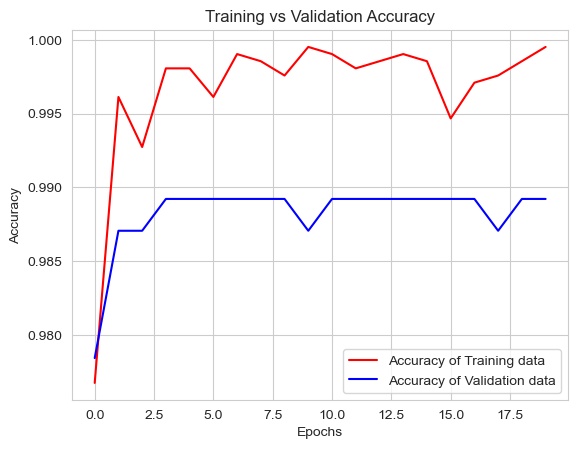

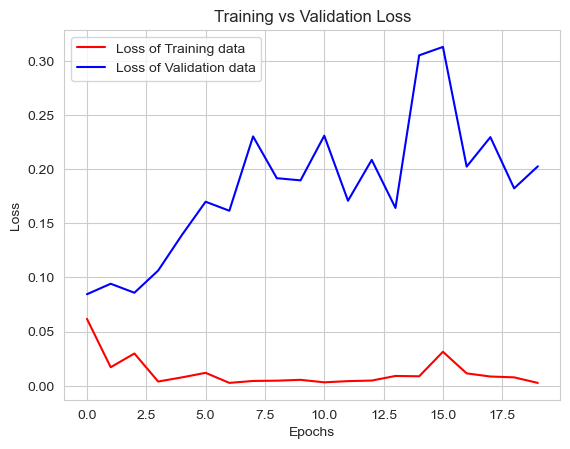

In [79]:
# Plot accuracy
epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.figure()

# Plot loss
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

<Figure size 640x480 with 0 Axes>

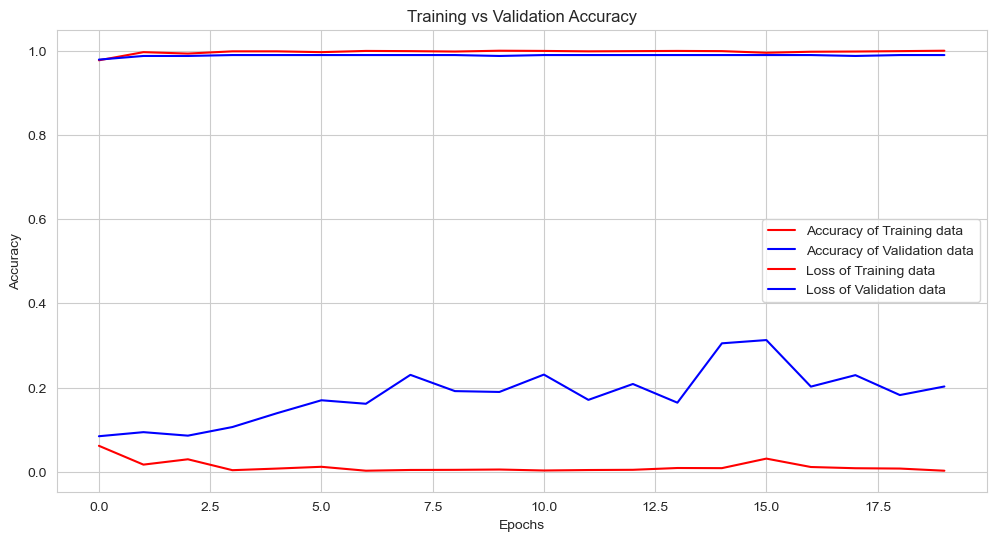

<Figure size 640x480 with 0 Axes>

In [80]:
# Plot accuracy
plt.figure(figsize=(12, 6))
epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.figure()


In [81]:
# Generate predictions on the test data
Model_Predict = model.predict(Test_Gen)
Model_Predict = np.argmax(Model_Predict, axis=1)

#Map predictions to their corresponding labels
Predict_Label = Test_Gen.class_indices
Predict_Label = dict((v, k) for k, v in Predict_Label.items())
Model_Predict = [Predict_Label[k] for k in Model_Predict]

print(Model_Predict[220:234])

15/15 [==============================] - 10s 547ms/step
['Fresh', 'Fresh', 'Fresh', 'Fresh', 'Fresh', 'Fresh', 'Fresh', 'Melted', 'Melted', 'Melted', 'Melted', 'Melted', 'Melted', 'Melted']


In [82]:
Test_Results = list(Test_Data["CATEGORY"])

In [83]:
Class_Report = classification_report(Test_Results, Model_Predict)
print(Class_Report)

              precision    recall  f1-score   support

       Fresh       1.00      0.98      0.99       232
      Melted       0.98      1.00      0.99       232

    accuracy                           0.99       464
   macro avg       0.99      0.99      0.99       464
weighted avg       0.99      0.99      0.99       464


Confusion Matrix:
[[227   5]
 [  0 232]]


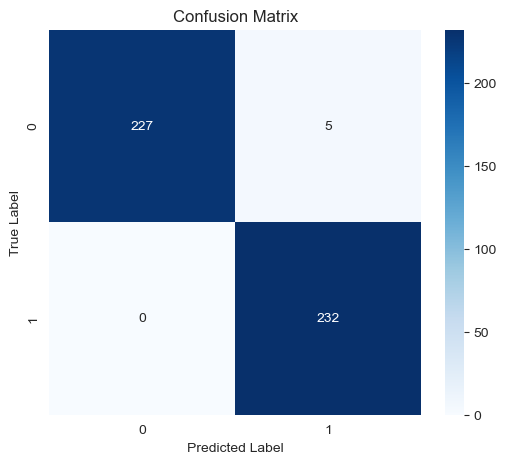

In [84]:
# Membuat confusion matrix
conf_matrix = confusion_matrix(Test_Results, Model_Predict)

# Menampilkan confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Menampilkan confusion matrix dengan heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

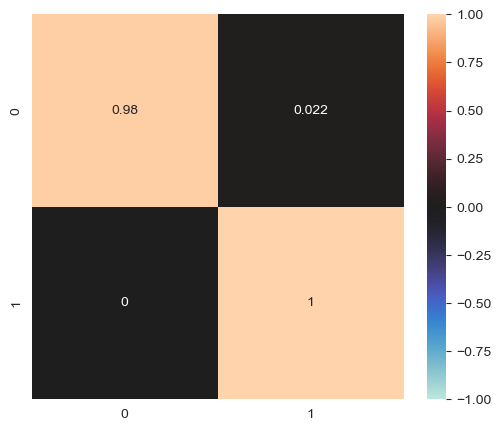

In [85]:
Conf_Report = confusion_matrix(Test_Results,Model_Predict, normalize="true")
figure = plt.figure(figsize=(6,5))
sns.heatmap(Conf_Report,vmax=1,center=0,vmin=-1,annot=True)
plt.show()

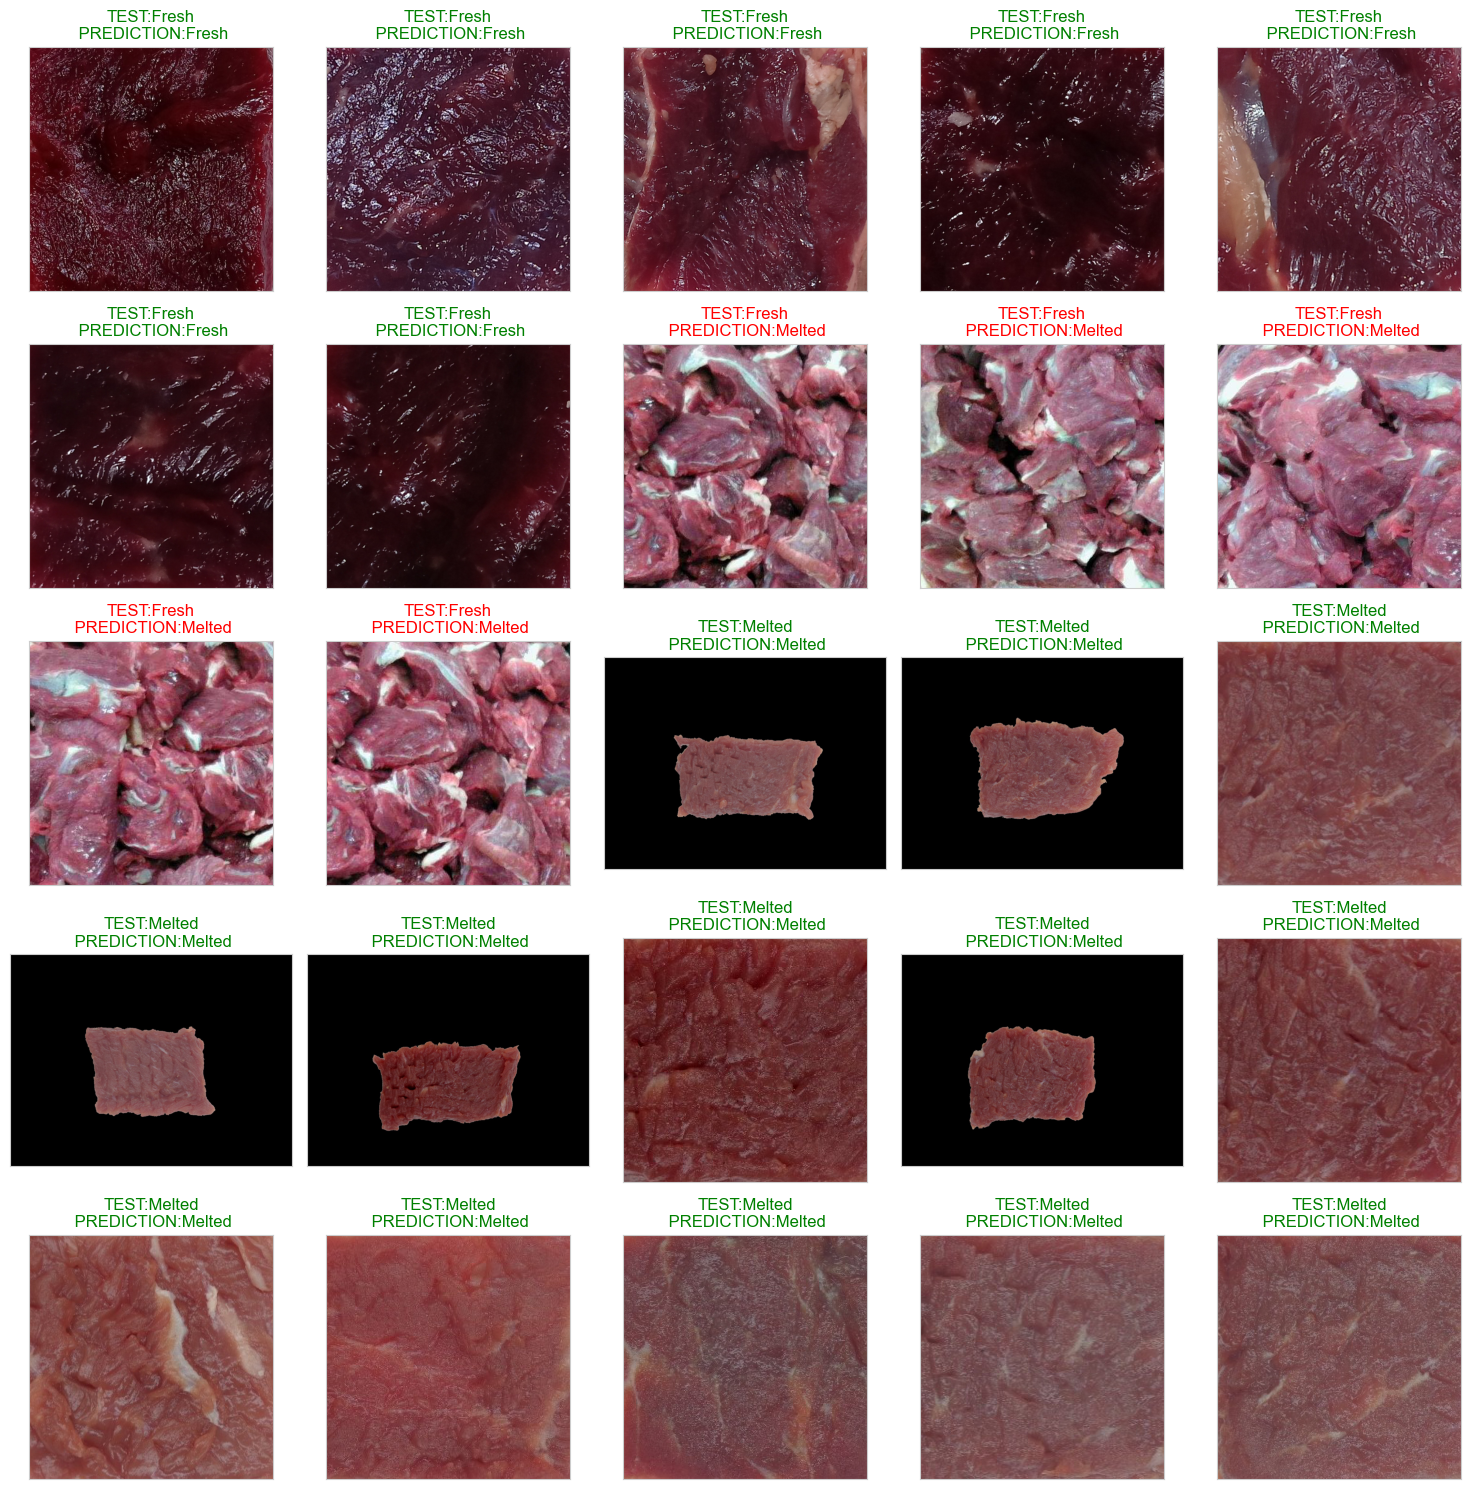

In [86]:
# Tentukan indeks untuk memulai dan mengakhiri pemilihan gambar
start_index = 220
end_index = 245

# Hitung jumlah kolom dan baris untuk grid gambar
num_rows = 5
num_cols = 5

# Buat gambar dengan grid subplot
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})

# Iterate melalui gambar yang akan ditampilkan
for i, ax in enumerate(axes.flat):
    # Hitung indeks gambar dan label prediksi yang sesuai
    index = start_index + i
    true_category = Test_Data.iloc[index]["CATEGORY"]
    prediction = Model_Predict[index]
    
    # Tentukan warna label berdasarkan kebenaran prediksi
    color = 'green' if true_category == prediction else 'red'
    
    # Tampilkan gambar dan label prediksi dengan warna yang sesuai
    ax.imshow(plt.imread(Test_Data.iloc[index]["JPG"]))
    ax.set_title(f"TEST:{true_category}\n PREDICTION:{prediction}", color=color)

# Tampilkan gambar
plt.tight_layout()
plt.show()


In [87]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_190 (B  (None, 111, 111, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_19